# Using the Snorkel-labeled Dataset for Text Classification

In the previous section, we showed how you can use _ktrain_ (a  wrapper for TensorFlow and Hugging Face Transformers) to perform text classification.
_ktrain_ helps anyone new to text classification jumpstart the use of transformer-based models, and enables people to get started quickly.

As you get familiar with using transformer-based models, you might want to leverage the full capabilities of the Hugging Face Python library directly.  
In this notebook, we show you how you can use Hugging Face and one of the state-of-art transformers in Hugging Face called _RoBERTa_.

_RoBERTa_ uses a similar architecture to _BERT_, and uses a byte-level BPE as a tokenizer.  _RoBERTa_ made several other optimizations to improve the _BERT_ architecture. These include bigger batch size, longer training time, and using more diversified training data.



In [1]:
%reload_ext autoreload
%autoreload 2



In [2]:
import torch
print(torch.__version__)

1.8.1


## Load relevant Python packages
Let us get started by loading the relevant _Hugging Face Transformer libraries_, and _sklearn_. 



In [6]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import transformers as tfs


### Checking availability of GPUs and type of GPU
Determine the number of available GPUs that can be used for training. In addition, we also print out the type of GPU.

In [7]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'GPU(s) available: {torch.cuda.device_count()} ')
    print('Device:', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPUs available. Default to use CPU')
    

GPU(s) available: 1 
Device: NVIDIA Tesla K80


## Data Preparation

In [13]:
# Read the Fake News Dataset and show the first few rows
fakenews_df = pd.read_csv('../data/fakenews_snorkel_labels.csv')
fakenews_df[['id', 'statement','snorkel_labels']].head()


,id,statement,snorkel_labels
0,1248,"During the Reagan era, while productivity incr...",1
1,4518,"""It costs more money to put a person on death ...",1
2,15972,Says that Minnesota Democratic congressional c...,0
3,11165,"""This is the most generous country in the worl...",1
4,14618,"""Loopholes in current law prevent ‘Unaccompani...",0


In [14]:
#fakenews_df['spk_statement'] = fakenews_df['speaker'] + " " + fakenews_df['statement'] 
fakenews_df['spk_statement'] = fakenews_df['statement'] 

In [15]:
fakenews_df['spk_statement'].head()

0    During the Reagan era, while productivity incr...
1    "It costs more money to put a person on death ...
2    Says that Minnesota Democratic congressional c...
3    "This is the most generous country in the worl...
4    "Loopholes in current law prevent ‘Unaccompani...
Name: spk_statement, dtype: object

In [16]:
X = fakenews_df.loc[:,['spk_statement', 'snorkel_labels']]
labels = X.snorkel_labels


In [17]:
# Get the unique labels 
categories = labels.unique()
categories

array([ 1,  0, -1])

In [18]:
#X = X[X['snorkel_labels'] >= 0] 
X = X[X['snorkel_labels'] >= 0] 


In [19]:
# count each of the labels
X['snorkel_labels'].value_counts()

1    6287
0    5859
Name: snorkel_labels, dtype: int64

## Preparing the training and test data

In [20]:
# Split the data into train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X['spk_statement'], X['snorkel_labels'], test_size=0.20, random_state=122520)

# withold test cases for testing
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.30, random_state=122420)


In [21]:
print("Test set: %d" % len(X_test))
print("Val set: %d" % len(X_val))

Test set: 1701
Val set: 729


In [22]:
X_train.head()

11974    Says North Carolina Rep. Renee Ellmers was the...
13124             Says coronavirus is just “the damn flu.”
9872     "54 senators said, let's do background checks,...
1398     Says U.S. Rep. Justin Amash "votes more with N...
6068     "We are accepting more legal immigrants than w...
Name: spk_statement, dtype: object

In [23]:
y_train.value_counts()

1    5028
0    4688
Name: snorkel_labels, dtype: int64

In [24]:
y_val.value_counts()

1    374
0    355
Name: snorkel_labels, dtype: int64

In [25]:
y_test.value_counts()

1    885
0    816
Name: snorkel_labels, dtype: int64

In [26]:
# Count of label 0 and 1 in the training data set
print("Rows in X_train %d : " % len(X_train))
y_train.value_counts()


Rows in X_train 9716 : 


1    5028
0    4688
Name: snorkel_labels, dtype: int64

In [27]:
X_train[5568]

'"Unemployment has fallen from 10 percent during the president’s first year in office to 8.5 percent today."'

In [28]:
print("Rows in X_train %d : " % len(X_val))
y_val.value_counts()


Rows in X_train 729 : 


1    374
0    355
Name: snorkel_labels, dtype: int64

## Preparing the Dataset - Tokenization
Perform tokenization using the RoBERTa tokenizer.

In [29]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the pre-trained roberta-base model using _RobertaForSequenceClassification.from_pretrained(...)_.
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')



In [30]:
# Test code for Tokenizer
text = X_train[5568][:50]
print(text)

# encode text
encoded_text = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print("inputs_ids")
print(encoded_text["input_ids"])

print("\nAttention mask")
print(encoded_text["attention_mask"])

"Unemployment has fallen from 10 percent during th
inputs_ids
[[0, 113, 2], [0, 791, 2], [0, 282, 2], [0, 242, 2], [0, 119, 2], [0, 642, 2], [0, 462, 2], [0, 139, 2], [0, 219, 2], [0, 119, 2], [0, 242, 2], [0, 282, 2], [0, 90, 2], [0, 2, 1], [0, 298, 2], [0, 102, 2], [0, 29, 2], [0, 2, 1], [0, 506, 2], [0, 102, 2], [0, 462, 2], [0, 462, 2], [0, 242, 2], [0, 282, 2], [0, 2, 1], [0, 506, 2], [0, 338, 2], [0, 139, 2], [0, 119, 2], [0, 2, 1], [0, 134, 2], [0, 288, 2], [0, 2, 1], [0, 642, 2], [0, 242, 2], [0, 338, 2], [0, 438, 2], [0, 242, 2], [0, 282, 2], [0, 90, 2], [0, 2, 1], [0, 417, 2], [0, 257, 2], [0, 338, 2], [0, 118, 2], [0, 282, 2], [0, 571, 2], [0, 2, 1], [0, 90, 2], [0, 298, 2]]

Attention mask
[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1

<AxesSubplot:>

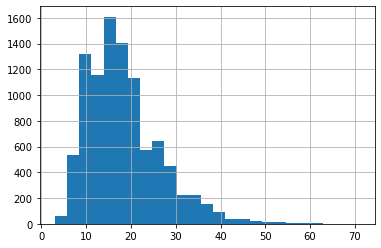

In [31]:
# Distribution of length of news
seq_len = [len(news.split()) for news in X_train]
pd.Series(seq_len).hist(bins = 25)

Note: Changes between v2.x to v3.x HuggineFace

Refer to https://discuss.huggingface.co/t/migration-guide-from-v2-x-to-v3-x-for-the-tokenizer-api/55

### Tokenization of the training and test dataset

In [33]:
# Use the Distilbert Tokenizer to tokenize and encode 

max_length = 256

tokenized_train = tokenizer(
    X_train.to_list(),
    padding='max_length',
    max_length = max_length,
    truncation=True,
    return_token_type_ids=False, 
)



In [34]:
tokenized_validation = tokenizer(
    X_val.to_list(),
    padding='max_length',
    max_length = max_length,
    truncation=True,
    return_token_type_ids=False
)

Next, we will convert the tokenized input_ids, attention mask, and labels into Tensors that we can use as inputs to training.

In [35]:
# Map integers to Tensors
train_input_ids_tensor = torch.tensor(tokenized_train["input_ids"])
train_attention_mask_tensor = torch.tensor(tokenized_train["attention_mask"])
train_labels_tensor = torch.tensor(y_train.to_list())


val_input_ids_tensor = torch.tensor(tokenized_validation ["input_ids"])
val_attention_mask_tensor = torch.tensor(tokenized_validation ["attention_mask"])
val_labels_tensor = torch.tensor(y_val.to_list())


In [36]:
# Show the converted tensors
print(train_input_ids_tensor)
print(train_attention_mask_tensor)
print(train_labels_tensor)

tensor([[    0,   104,  4113,  ...,     1,     1,     1],
        [    0,   104,  4113,  ...,     1,     1,     1],
        [    0,   113,  4283,  ...,     1,     1,     1],
        ...,
        [    0,   104,  4113,  ...,     1,     1,     1],
        [    0,   113, 14696,  ...,     1,     1,     1],
        [    0,   104,  4113,  ...,     1,     1,     1]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([0, 0, 1,  ..., 0, 1, 0])


In [37]:
print (len(train_labels_tensor))
print (len(train_attention_mask_tensor))
print (len(train_input_ids_tensor))

9716
9716
9716


In [38]:
print (len(val_labels_tensor))
print (len(val_attention_mask_tensor))
print (len(val_input_ids_tensor))

729
729
729


### Converting to a TensorDataset
Before we start to fine-tune the RoBERTa model, we will create the DataLoader for both the training and validation data. The DataLoader will be used during the fine-tuning of the model. To do this, we first convert the inputs_ids, attention_mask, and labels to a _TensorDataset_. Next, we create the DataLoader using the TensorDataset as inputs and specify the batch size. We set the variable _batch_size_ to be 16.

In [39]:
# Preparing the DataLaoders
from torch.utils.data import TensorDataset, DataLoader

# Specify a batch size of 32
#batch_size = 32
batch_size = 16

# 1. Create a Tensor Datset
# 2. Define the data sampling approach
# 3. Create the DataLoader
train_data_tensor = TensorDataset(train_input_ids_tensor, train_attention_mask_tensor, train_labels_tensor)
train_dataloader = DataLoader(train_data_tensor, batch_size=batch_size, shuffle=True)

val_data_tensor = TensorDataset(val_input_ids_tensor, val_attention_mask_tensor, val_labels_tensor)
val_dataloader = DataLoader(val_data_tensor, batch_size=batch_size, shuffle=True)




In [40]:
 for step,batch in enumerate(train_dataloader):
     if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

  Batch    50  of    608.
  Batch   100  of    608.
  Batch   150  of    608.
  Batch   200  of    608.
  Batch   250  of    608.
  Batch   300  of    608.
  Batch   350  of    608.
  Batch   400  of    608.
  Batch   450  of    608.
  Batch   500  of    608.
  Batch   550  of    608.
  Batch   600  of    608.


## Model Training 

In [43]:
from transformers import get_linear_schedule_with_warmup

num_epocs = 2
total_steps = num_epocs * len(train_dataloader)  

### Using the pre-trained RobertaForSequenceClassification model
Next, we specify the optimizer that will be used. For this exercise, we will use the _AdamW_ optimizer, which is part of the _HuggingFace_ optimization module. The _AdamW_ optimizer implements the Adam algorithm with the weight decay fix that can be used when fine-tuning models.

In addition, you will notice that we specified a scheduler, using  _get_linear_schedule_with_warmup()_. This creates a schedule with a learning rate that decreases linearly, using the initial learning rate that was set in the optimizer as the reference point. The learning rate decreases linearly after a warmup period.


In [44]:
# Use the Hugging Face optimizer 
from transformers import AdamW

# specify the optimizer 
model = RobertaForSequenceClassification.from_pretrained('roberta-base',return_dict=True)
optimizer = AdamW(model.parameters(), lr =  3e-5)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 100, num_training_steps = total_steps)





Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [45]:
#freeze the top layers
#for param in model.base_model.parameters():
#    param.requires_grad = False

In [52]:
def train():
  total_loss = 0.0
  total_preds=[]

  # Set model to training mode
  model.train()  
  #model.zero_grad()        

  # Iterate over the batch in dataloader
  for step,batch in enumerate(train_dataloader):  
    # Get it batch to leverage device
    batch = [r.to(device) for r in batch]
    input_ids, mask, labels = batch

    model.zero_grad() 
    outputs = model(input_ids,attention_mask=mask, labels=labels)
    
    loss = outputs.loss
    logits = outputs.logits 

    # add on to the total loss
    total_loss = total_loss + loss

    # backward pass 
    loss.backward()

    # Reduce the effects of the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # append the model predictions
    total_preds.append(outputs)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  


  #returns the loss and predictions
  return avg_loss


In [53]:
# function for evaluating the model
def evaluate():
  total_loss = 0.0
  total_preds = []

  # Set model to evaluation mode
  model.eval()   
  
  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    batch = [t.to(device) for t in batch]
    input_ids, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      #outputs = model(input_ids, labels=labels)
      outputs = model(input_ids,attention_mask=mask, labels=labels)

      loss = outputs.loss
      logits = outputs.logits
        
      # add on to the total loss
      total_loss = total_loss + loss
      total_preds.append(outputs)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  return avg_loss

In [54]:
import gc

gc.collect()
torch.cuda.empty_cache()

### Fine-tuning the RoBERTa model


In [55]:
train_losses=[]
valid_losses=[]

# set initial loss to infinite
best_val_loss = float('inf')

#push the model to GPU
model = model.to(device)

# Specify the name of the saved weights file
saved_file = "fakenewsnlp-saved_weights.pt"

#for each epoch
for epoch in range(num_epocs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, num_epocs))
    
    train_loss = train()
    val_loss = evaluate()
    
    print(f' Loss: {train_loss:.3f} - Val_Loss: {val_loss:.3f}')

    #save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),  saved_file)
    
    # Track the training/validation loss
    train_losses.append(train_loss)
    valid_losses.append(val_loss) 

# Release the memory in GPU
model.cpu()
torch.cuda.empty_cache()



 Epoch 1 / 2
 Loss: 0.617 - Val_Loss: 0.576

 Epoch 2 / 2
 Loss: 0.511 - Val_Loss: 0.565


## Testing the Fine-tuned Model
Let's run the fine-tuned RoBERTa model on the test dataset. 
Similar to how we prepared the training and validation datasets earlier, we will start by tokenizing the test data, performing truncation, and padding.

We iterate through multiple batches of data provided by _test_dataloader_. 
To obtain the predicted label, we use _torch.argmax()_ to get the label using the logits that are provided. 
The predicted results are then stored in the variable _predictions_.

In [58]:
tokenized_test = tokenizer(
    X_test.to_list(),
    padding='max_length',
    max_length = max_length,
    truncation=True,
    return_token_type_ids=False
)


In [59]:
# convert input_ids, attention_mask and labels to tensor
test_input_ids_tensor = torch.tensor(tokenized_test["input_ids"])
test_attention_mask_tensor = torch.tensor(tokenized_test["attention_mask"])
test_labels_tensor = torch.tensor(y_test.to_list())


In [60]:
test_data_tensor = TensorDataset(test_input_ids_tensor,
                               test_attention_mask_tensor, 
                               test_labels_tensor)

test_dataloader = DataLoader(test_data_tensor, 
                             batch_size=batch_size, 
                             shuffle=False)

In [61]:
# Let's set the model to evaluation mode
model.eval()
predictions, true_labels = [],[]

In [63]:
total_preds = []
predictions = []

model = model.to(device)

# Set model to evaluation mode
model.eval()   
  
# iterate over batches
for step,batch in enumerate(test_dataloader):
   batch = [t.to(device) for t in batch]
   input_ids, mask, labels = batch

   # deactivate autograd
   with torch.no_grad():
      outputs = model(input_ids,attention_mask=mask)
      logits = outputs.logits
    
      predictions.append(torch.argmax(logits, dim=1).tolist())
      total_preds.append(outputs)


model.cpu()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [64]:
predictions_f = list(np.concatenate(predictions).flat)

In [65]:
ground_truth = y_test.tolist()
ground_truth[:10]

[0, 1, 1, 1, 0, 0, 1, 1, 0, 1]

In [67]:
from sklearn.metrics import classification_report

y_true = y_test.tolist()
y_pred =  list(np.concatenate(predictions).flat)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.52      0.62       816
           1       0.66      0.85      0.74       885

    accuracy                           0.69      1701
   macro avg       0.71      0.69      0.68      1701
weighted avg       0.71      0.69      0.68      1701



In [68]:
from sklearn.metrics import confusion_matrix


print(confusion_matrix(ground_truth, predictions_f))

[[426 390]
 [131 754]]


In [69]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Accuracy: %.4f" % accuracy_score(ground_truth,predictions_f))
print("F1 score: %.4f" % f1_score(ground_truth,predictions_f))
print("AUC: %.4f" % roc_auc_score(ground_truth,predictions_f))

Accuracy: 0.6937
F1 score: 0.7432
AUC: 0.6870
